In [1]:
# Import libraries
using Turing
using LinearAlgebra
using Distributions
using MultivariateStats
import MultivariateStats: reconstruct
using GaussianProcesses
using StatsBase
using Statistics
using Suppressor
using JLD2
using CSV
using DataFrames, DataFramesMeta
using SplitApplyCombine
using KernelFunctions
using MCMCChains
using PyCall
using PyPlot
using Printf
import PyCall.pyfunction
using Missings

os = pyimport("os")
pyimport("scienceplots")
np = pyimport("numpy")


PyCall.pygui(:tk)

FONTSIZE=20.5;

In [13]:
#####################################################################################################################
#####################################################################################################################
#####################################################################################################################
###############################                SLR Projection Learning Tables             ###########################
#####################################################################################################################
#####################################################################################################################
#####################################################################################################################

In [14]:
# All years 2016-2300
all_years_no_gap = collect(range(2016, step=1, length=285))

yrs_dict = Dict{Int64, Int64}()
for (idx,yr) in enumerate(all_years_no_gap)
        yrs_dict[yr] = idx
end


Realizations = [string(i) for i in 1:100];

cal_years = collect(range(2030,step=15,length=19));

In [68]:
# The years of projection considered
chosen_projection_years = [2100,2200,2300]

# Initialize empty arrays (Some entries will be missing due to calibration past year of projection)
all_bounds   = Array{Array{Union{Missing,Tuple{Missing, Missing},Tuple{Float64,Float64},Int64}}}(undef, length(chosen_projection_years))
all_widths   = zeros(3,20)
all_width_variation = zeros(3,19)
# For each projection year considered
for (n, year) in enumerate(chosen_projection_years)
    
    proj_yr_idx = yrs_dict[year]
    proj_bounds = Array{Union{Missing,Float64}}(undef,length(Realizations),19,2)
    proj_widths = zeros(100,19)
    
    # For each of the 100 trajectories considered
    for j in 1:length(Realizations)
        # For each of the 19 calibrating years considered
        for (iter,yr) in enumerate(cal_years[1:end])
                cal_year_matrix = JLD2.load("../Data/Projection_Data/R_$(Realizations[j])/$(Realizations[j])-year$(yr)pred_VAF.jld2",
                    "sample_post_mm_ssp5")
                proj_bounds[j,iter,1] = quantile(cal_year_matrix[proj_yr_idx,:], 0.05)
                proj_bounds[j,iter,2] = quantile(cal_year_matrix[proj_yr_idx,:], 0.95)
                proj_widths[j,iter] = proj_bounds[j,iter,2] - proj_bounds[j,iter,1]
        end
    end

    # Average across the 100 trajectories
    avg_bounds = dropdims(mean(proj_bounds,dims=1),dims=1)
    avg_widths = dropdims(mean(proj_widths,dims=1),dims=1)

    # Compute 66% credible interval of the 90% interval widths across the 100 trajectories
    width_variation_interval = np.quantile(proj_widths, 0.83,axis=0) .- np.quantile(proj_widths,0.17,axis=0) #31
    println(size(width_variation_interval))

#35
    # Load the present day projections
    present_projections = JLD2.load("../Data/Projection_Data/2015_SLR_Projections.jld2","present2015_post_mm_ssp5")
    present_lower = quantile(present_projections[proj_yr_idx,:], 0.05)
    present_upper = quantile(present_projections[proj_yr_idx,:], 0.95)
    present_width = present_upper - present_lower

    # Add present day projections to beginning of lists above
    bounds_w_present = vcat([present_lower;; present_upper], avg_bounds)
    widths_w_present = vcat([present_width], avg_widths);
    # Store the bounds as tuples in one matrix
    slr_tuple_bounds = [(round(bounds_w_present[i,1],sigdigits=6),round(bounds_w_present[i,2],sigdigits=6)) for i in 1:length(bounds_w_present[:,1])]

    # Push this projection years quantities to list containing all the projection years
    all_bounds[n]   = slr_tuple_bounds
    all_widths[n,:]   =  widths_w_present #50
    all_width_variation[n,:]  =  width_variation_interval
    
end


(19,)
19,)
,)9


In [69]:
println(all_widths[2,:])

[65.2260970018066, 63.223472048119355, 52.87982957991175, 40.40856310394748, 22.92003701112505, 21.88034008032368, 20.51554395273234, 17.383546070930496, 15.580622587188838, 14.811304933798551, 14.46581014990449, 13.675259051885634, 12.230027482694414, 10.0191244804931, 9.21324966816602, 9.066101596568439, 9.005725937598553, 8.959227706800256, 8.926838164464675, 8.892137293024838]


In [70]:

println(all_width_variation[1,:])

[0.6917257860818511, 0.5029927562853862, 0.9840721614802495, 2.0694298497145867, 2.2922358100077425, 2.394392564503674, 2.0022546599479636, 2.0418597647655274, 2.018789027369745, 1.9994231591564038, 1.8273246345369039, 1.4203912392187235, 1.409354777294143, 1.3095891668027209, 1.3099056962649485, 1.219061343049783, 1.1985564955571824, 1.1510378615953565, 1.1344588752675957]


In [71]:
println(all_bounds[2,:])

Array{Union{Missing, Tuple{Missing, Missing}, Int64, Tuple{Float64, Float64}}}[[(0.944836, 66.1709), (1.23296, 64.4564), (3.43269, 56.3125), (6.86573, 47.2743), (12.0981, 35.0182), (12.6329, 34.5132), (12.9738, 33.4893), (14.0551, 31.4387), (14.7472, 30.3278), (15.2644, 30.0757), (15.6047, 30.0705), (16.0973, 29.7726), (16.8119, 29.0419), (18.1494, 28.1685), (18.6718, 27.8851), (18.7912, 27.8573), (18.7758, 27.7816), (18.7833, 27.7426), (18.8088, 27.7357), (18.8352, 27.7273)]]


In [72]:
df_cal_years = collect(range(2015,step=15,length=20));
df_cal_years = Int.(df_cal_years)

# Add the years of calibration as another column
bounds_w_years = hcat(df_cal_years, reduce(hcat, all_bounds))
widths_w_years = hcat(df_cal_years, all_widths')
width_var_w_years = hcat(df_cal_years[2:end],all_width_variation' )

col_names = ["Latest year of calibration","2100", "2200","2300"]

# Convert to dataframes before saving to disc
slr_df_bounds  = DataFrame(bounds_w_years, col_names)
slr_df_widths  = DataFrame(widths_w_years, col_names)
slr_df_width_var = DataFrame(width_var_w_years, col_names)
allowmissing!(slr_df_bounds) 
allowmissing!(slr_df_widths) 
allowmissing!(slr_df_width_var);

In [73]:
# Remove data that has been calibrated past its projection year (i.e projections for year 2100 with parameters calibrated in 2105)
for yr in col_names[2:3]
    n_useful = (parse(Int, yr) - 2015) ÷ 15
    slr_df_bounds[n_useful+2:end, yr] .= missing
    slr_df_widths[n_useful+2:end, yr] .= missing
    slr_df_width_var[n_useful+1:end, yr] .= missing    

end

#Calculate total percent decrease of 90% cred interval width
pct_change2100 = ((slr_df_widths[1,2] - slr_df_widths[6,2]) /  slr_df_widths[1,2]) * 100
pct_change2200 = ((slr_df_widths[1,3] - slr_df_widths[13,3]) /  slr_df_widths[1,3]) * 100
pct_change2300 = ((slr_df_widths[1,4] - slr_df_widths[19,4]) /  slr_df_widths[1,4]) * 100

# Make a 1×7 row: first element is label, then pct_change values
new_row = hcat("total_%_decrease", pct_change2100, pct_change2200, pct_change2300)
println(typeof(new_row))
# Convert to DataFrame with the same column names
new_df = DataFrame(new_row, col_names)


# Append to params_df_widths
append!(slr_df_widths, new_df, promote=true) #22
#println(slr_df_widths)

CSV.write("../Data/SLR_Learning_Tables/CI_bounds.csv", slr_df_bounds)
CSV.write("../Data/SLR_Learning_Tables/CI_widths.csv", slr_df_widths)
CSV.write("../Data/SLR_Learning_Tables/CI_width_variation.csv",  slr_df_width_var)

Matrix{Any}


"../Data/SLR_Learning_Tables/CI_width_variation.csv"

In [74]:
# CALCULATING THE YEAR TO YEAR CHANGE IN 90% UNCERTAINTY RANGES FOR PROJECTIONS OF THE YEARS 2100, 2200, 2300
proj_years = [2100,2200,2300]
cal_years = collect(range(2015, step=15, length=20))

Δ_proj_widths_yty = Array{Array{Union{Float64, Missing}}}(undef, 6)
for (i,yr) in enumerate(proj_years)
    n_cal_years = ((yr - 2015) ÷ 15) + 1
    # Calculate total learning
    present_row_idx = only(findall(x -> x == 2015, cal_years))
    present_diff = (i == 3) ? slr_df_widths[n_cal_years - 1, i+1] - slr_df_widths[present_row_idx,i+1] : slr_df_widths[n_cal_years, i+1] - slr_df_widths[present_row_idx,i+1]
    abs_change = Array{Union{Float64, Missing}}(undef, 20)
    pct_change = Array{Union{Float64, Missing}}(undef, 20)
    # Calculate the year to year change and percent of total change
    proj_yr_widths = slr_df_widths[!,i+1]
    abs_change[1:19] = proj_yr_widths[2:20] - proj_yr_widths[1:19] #15
    pct_change[1:19] = (abs_change[1:19] ./ present_diff) .* 100
    # Add the total change to the end of the list
    abs_change[20] = present_diff
    # Concatenate to the full matrix
    Δ_proj_widths_yty[2*i-1] = abs_change
    Δ_proj_widths_yty[2*i] = pct_change
        
end


In [75]:
# Labels for datframe rows
learn_periods = vcat(["$(cal_years[i]) - $(cal_years[i+1])" for i in 1:(length(cal_years) - 1)], ["Total learning"])
# Collect labels with data
mat_yty_width_change = hcat(learn_periods, reduce(hcat, Δ_proj_widths_yty))
# We don't care about the change in uncertainty past the point of projection
mat_yty_width_change[6,2] = 0.0
mat_yty_width_change[6,3] = 0.0
mat_yty_width_change[13,4] = 0.0
mat_yty_width_change[13,5] = 0.0
mat_yty_width_change[19,6] = 0.0
mat_yty_width_change[19,7] = 0.0
# Column labels
col_names = ["Learning_Period","Δ_2100","Δ_%_2100","Δ_2200","Δ_%_2200", "Δ_2300","Δ_%_2300"]
df_yty_width_change  = DataFrame(mat_yty_width_change, col_names)
CSV.write("../Data/SLR_Learning_Tables/yr_to_yr_change_in_widths.csv",   df_yty_width_change)

"../Data/SLR_Learning_Tables/yr_to_yr_change_in_widths.csv"

In [76]:
# CALCULATING THE YEAR TO YEAR CHANGE IN 90% UNCERTAINTY RANGE STANDARD DEVIATION FOR PROJECTIONS OF THE YEARS 2100, 2200, 2300
proj_years = [2100,2200,2300]
cal_years = collect(range(2030, step=15, length=19))

Δ_proj_width_var_yty = Array{Array{Union{Float64, Missing}}}(undef, 6)
for (i,yr) in enumerate(proj_years)
    n_cal_years = ((yr - 2030) ÷ 15) + 1
    # Calculate total learning
    present_row_idx = only(findall(x -> x == 2030, cal_years))
    present_diff = (i == 3) ? slr_df_width_var[n_cal_years - 1, i+1] - slr_df_width_var[present_row_idx,i+1] : slr_df_width_var[n_cal_years, i+1] - slr_df_width_var[present_row_idx,i+1]
    abs_change = Array{Union{Float64, Missing}}(undef, 19)
    pct_change = Array{Union{Float64, Missing}}(undef, 19)
    # Calculate the year to year change and percent of total change
    proj_yr_width_var = slr_df_width_var[!,i+1]
    abs_change[1:18] = proj_yr_width_var[2:19] - proj_yr_width_var[1:18]
    pct_change[1:18] = (abs_change[1:18] ./ present_diff) .* 100
    # Add the total change to the end of the list
    abs_change[19] = present_diff
    # Concatenate to the full matrix
    Δ_proj_width_var_yty[2*i-1] = abs_change
    Δ_proj_width_var_yty[2*i] = pct_change
        
end


In [77]:
# Labels for datframe rows
learn_periods = vcat(["$(cal_years[i]) - $(cal_years[i+1])" for i in 1:(length(cal_years) - 1)], ["Total learning"])
# Collect labels with data
mat_yty_std_change = hcat(learn_periods, reduce(hcat, Δ_proj_width_var_yty))
# We don't care about the change in uncertainty variation past the point of projection
mat_yty_std_change[5,2] =  0.0 
mat_yty_std_change[5,3] = 0.0
mat_yty_std_change[12,4] = 0.0
mat_yty_std_change[12,5] = 0.0
mat_yty_std_change[18,6] = 0.0
mat_yty_std_change[18,7] = 0.0
# Column labels
col_names = ["Learning_Period","Δ_2100","Δ_%_2100","Δ_2200","Δ_%_2200", "Δ_2300","Δ_%_2300"]
df_yty_std_change  = DataFrame(mat_yty_std_change, col_names)
CSV.write("../Data/SLR_Learning_Tables/yr_to_yr_change_in_width_variation.csv",   df_yty_std_change)

"../Data/SLR_Learning_Tables/yr_to_yr_change_in_width_variation.csv"

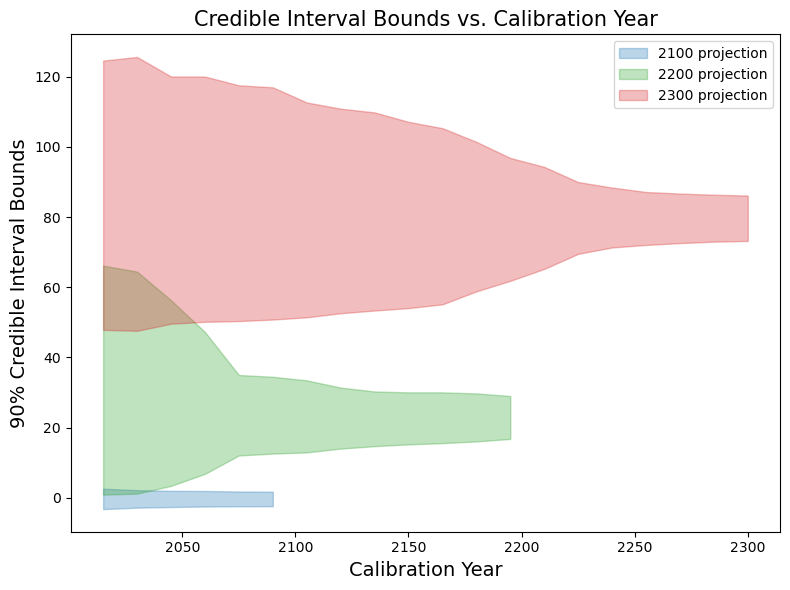

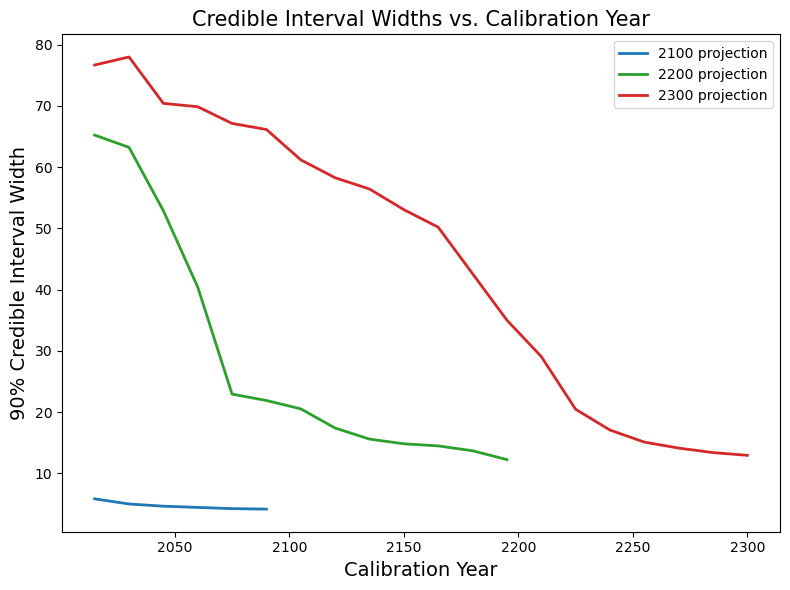

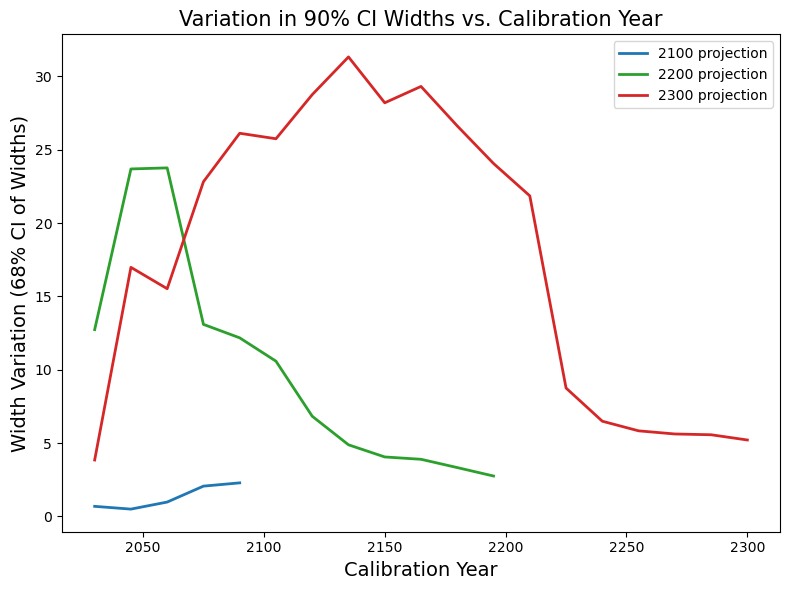

In [93]:
# Sanity Check

# === Load data ===
bounds = CSV.read("../Data/SLR_Learning_Tables/CI_bounds.csv", DataFrame)
widths = CSV.read("../Data/SLR_Learning_Tables/CI_widths.csv", DataFrame)
width_var = CSV.read("../Data/SLR_Learning_Tables/CI_width_variation.csv", DataFrame)

# === Extract data ===
years = bounds[!, "Latest year of calibration"]
proj_years = [2100, 2200, 2300]
colors = Dict(2100 => "#1f77b4", 2200 => "#2ca02c", 2300 => "#d62728")

# === Helper: parse bounds tuples ===
function parse_bounds_column(col)
    lowers = Float64[]
    uppers = Float64[]
    for entry in col
        if isnothing(entry) || occursin("missing", string(entry))
            push!(lowers, NaN); push!(uppers, NaN)
        else
            parts = split(strip(string(entry), ['(', ')']), ",")
            if length(parts) == 2
                push!(lowers, parse(Float64, strip(parts[1])))
                push!(uppers, parse(Float64, strip(parts[2])))
            else
                push!(lowers, NaN); push!(uppers, NaN)
            end
        end
    end
    return lowers, uppers
end
 #32
# === Plot 1: Credible Interval Bounds ===
figure(figsize=(8,6))
for yr in proj_years
    lowers, uppers = parse_bounds_column(bounds[!, string(yr)])
    fill_between(years, lowers, uppers, color=colors[yr], alpha=0.3, label="$(yr) projection")
end
xlabel("Calibration Year", fontsize=14)
ylabel("90% Credible Interval Bounds", fontsize=14)
title("Credible Interval Bounds vs. Calibration Year", fontsize=15)
legend()
tight_layout()
#savefig("../Plots/SLR_bounds_vs_year.pdf")
show()
# === Plot 2: Credible Interval Widths ===
figure(figsize=(8,6))
for yr in proj_years
    plot(years[1:((yr - 2015) ÷ 15)+1], widths[1:((yr - 2015) ÷ 15)+1, string(yr)], color=colors[yr], lw=2, label="$(yr) projection") #50
end
xlabel("Calibration Year", fontsize=14)
ylabel("90% Credible Interval Width", fontsize=14)
title("Credible Interval Widths vs. Calibration Year", fontsize=15)
legend()
tight_layout()
#savefig("../Plots/SLR_widths_vs_year.pdf")
show()

# === Plot 3: Credible Interval Width Variation ===
figure(figsize=(8,6))
for yr in proj_years
    plot(width_var[1:((yr - 2015) ÷ 15), "Latest year of calibration"], width_var[1:((yr - 2015) ÷ 15), string(yr)],
         color=colors[yr], lw=2, label="$(yr) projection")
end
xlabel("Calibration Year", fontsize=14)
ylabel("Width Variation (68% CI of Widths)", fontsize=14)
title("Variation in 90% CI Widths vs. Calibration Year", fontsize=15)
legend()
tight_layout()
#savefig("../Plots/SLR_width_variation_vs_year.pdf")
show()
